# Week 1 Notebook 6
# Case Study: Spotify track ratings exploration

## 1  Setup & Background


Dataset: **Spotify track ratings**  `spotify_track_ratings.csv`

Source: MaharshiPandya, Kaggle, link: https://www.kaggle.com/datasets/maharshipandya/-spotify-tracks-dataset/data 



Let's start with the following tasks without touching the data.

TODO 

Read the Data Card of the spotify track ratings data on Kaggle and answer the following questions

1. What’s the unit of analysis in this dataset?

2. How many rows and columns are there?

3. Name three numeric features.

4. What time span do the tracks in this dataset cover?

5. What license governs the dataset? In your own words, what does that allow (or restrict) you to do?

6. If you were going to add one new column to make the dataset more useful, what would it be and why?


TODO

What are potential questions of interest to study in this dataset? 
Examples: 
1. Predicting popularity of a new album
2. Suggestions on other features of the track to achieve maximum popularity for a given artist

TODO

Suppose that we are interested in Question 1 and Question 2. What variables in the dataset do you think will be of use?

Example answers (Q1)


- Core audio descriptors:	danceability, energy, acousticness, instrumentalness, liveness, speechiness, valence, tempo, loudness	

- Structure / composition:	duration_ms, key, mode, time_signature	

- Release timing:	release_year, release_month, release_day (or a derived track_age)	 

- Content flag:	explicit (0/1) 

Example answers (Q2)

- Artist baseline context (for conditioning the recommendations): artist_id, artist_mean_popularity, artist_median_danceability, years_active 

- Knobs the artist can actually turn (optimization candidates)
    - Energy & vibe:	danceability, energy, valence
    - Sonic texture:	acousticness, instrumentalness, liveness, speechiness
    - Pace & punch:	tempo, loudness, duration_ms
    - Musical key:	key, mode, time_signature
    - Release moment:	release_month 
    - Content label:	explicit flag

We now turn to the actual dataset. You want to store your data in a designated folder. In this case, create a new folder named "data" in the same folder where your Github repository lives. 

In [66]:
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt
import plotly.graph_objects as go

from plotly.subplots import make_subplots

sns.set_theme(style="whitegrid", context="talk")

df = pd.read_csv("dataset.csv")
print(f"Loaded {len(df):,} tracks")


Loaded 114,000 tracks


In [67]:
# ---- Quick data health-check ------------------------------------------------
display(df.head())                     # peek at the first 5 rows

# overall shape & dtypes / missing values
df.info(show_counts=True)

# numeric summary (mean, std, quartiles, etc.)
df.describe().T

# how many unique values per non-numeric column
(cat_counts := df.select_dtypes(exclude=np.number)
                 .nunique()
                 .sort_values(ascending=False)
                 .rename("n_unique"))

display(cat_counts.to_frame())

# percent of rows with at least one null (sanity check)
null_pct = df.isna().any(axis=1).mean() * 100
print(f"\nRows with ≥1 missing value: {null_pct:.1f}%")


,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,...,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,...,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,...,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,...,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114000 entries, 0 to 113999
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        114000 non-null  int64  
 1   track_id          114000 non-null  object 
 2   artists           113999 non-null  object 
 3   album_name        113999 non-null  object 
 4   track_name        113999 non-null  object 
 5   popularity        114000 non-null  int64  
 6   duration_ms       114000 non-null  int64  
 7   explicit          114000 non-null  bool   
 8   danceability      114000 non-null  float64
 9   energy            114000 non-null  float64
 10  key               114000 non-null  int64  
 11  loudness          114000 non-null  float64
 12  mode              114000 non-null  int64  
 13  speechiness       114000 non-null  float64
 14  acousticness      114000 non-null  float64
 15  instrumentalness  114000 non-null  float64
 16  liveness          11

,n_unique
track_id,89741
track_name,73608
album_name,46589
artists,31437
track_genre,114
explicit,2



Rows with ≥1 missing value: 0.0%


> **Tip**  For quicker EDA, work on a smaller data (e.g., a random subset of data. Switch back to full data for final analysis.

In [68]:
SEED = 42              # for reproducibility
sample = df.sample(5000, random_state=SEED)   
sample.head()

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
113186,113186,6KwkVtXm8OUp2XffN5k7lY,Hillsong Worship,No Other Name,No Other Name,50,440247,False,0.369,0.598,...,-6.984,1,0.0304,0.00511,0.000000,0.176,0.0466,148.014,4,world-music
42819,42819,2dp5I5MJ8bQQHDoFaNRFtX,Internal Rot,Grieving Birth,Failed Organum,11,93933,False,0.171,0.997,...,-3.586,1,0.1180,0.00521,0.801000,0.420,0.0294,122.223,4,grindcore
59311,59311,5avw06usmFkFrPjX8NxC40,Zhoobin Askarieh;Ali Sasha,Noise A Noise 20.4-1,"Save the Trees, Pt. 1",0,213578,False,0.173,0.803,...,-10.071,0,0.1440,0.61300,0.001910,0.195,0.0887,75.564,3,iranian
91368,91368,75hT0hvlESnDJstem0JgyR,Bryan Adams,All I Want For Christmas Is You,Merry Christmas,0,151387,False,0.683,0.511,...,-5.598,1,0.0279,0.40600,0.000197,0.111,0.5980,109.991,3,rock
61000,61000,4bY2oZGA5Br3pTE1Jd1IfY,Nogizaka46,バレッタ TypeD,月の大きさ,57,236293,False,0.555,0.941,...,-3.294,0,0.0481,0.48400,0.000000,0.266,0.8130,92.487,4,j-idol


## 2. Preprocessing


Below we perform light preprocessing:

1. **Missing values** — drop rows with missing `popularity` 
2. **Derived features** — map numeric `key` to note names for readability.
3. **Categorical encoding prep** — convert `explicit`, `mode`, and `time_signature` to `category` dtype.

> Feel free to extend this section (e.g., scaling, one‑hot encoding) once the modeling pipeline is introduced.

> **Tip** This section will be revisited once the modeling pipeline is finalized.

In [69]:

# 1) Drop rare missing popularity rows
pop_missing = sample['popularity'].isna().sum()
print(f"Dropping {pop_missing} rows with null popularity")
sample= sample.dropna(subset=['popularity'])


Dropping 0 rows with null popularity


In [70]:
# 2) Derived features
key_names = {
    0: "C", 1: "C#/Db", 2: "D", 3: "D#/Eb", 4: "E", 5: "F",
    6: "F#/Gb", 7: "G", 8: "G#/Ab", 9: "A", 10: "A#/Bb", 11: "B"
}
sample['key_name'] = sample['key'].map(key_names)
print(sample['key_name'])


113186        G
42819         G
59311         A
91368     F#/Gb
61000         A
          ...  
18241         F
42766     D#/Eb
52377     G#/Ab
27380         E
75356         G
Name: key_name, Length: 5000, dtype: object


In [71]:

# 3) Convert some ints to category for efficient memory + explicit semantics
for col in ['explicit', 'mode', 'time_signature']:
    if col in sample.columns:
        sample[col] = sample[col].astype('category')

print('Preprocessing complete. sample shape:', sample.shape)


Preprocessing complete. sample shape: (5000, 22)


## 3  Univariate summary


### 3.1 Response variable

In [72]:
import plotly.express as px
# (a) Track popularity distribution with plotly express
px.histogram(sample, x='popularity', nbins=50, title='Track Popularity Distribution').show()


Text(0.5, 1.0, 'Track popularity distribution')

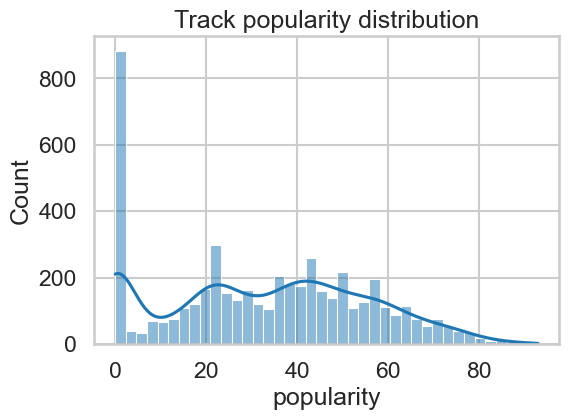

In [73]:
# (b) Track popularity distribution with seaborn
fig, ax = plt.subplots(figsize=(6,4))
sns.histplot(sample['popularity'], bins=40, kde=True, ax=ax, color='tab:blue')
ax.set_title('Track popularity distribution')

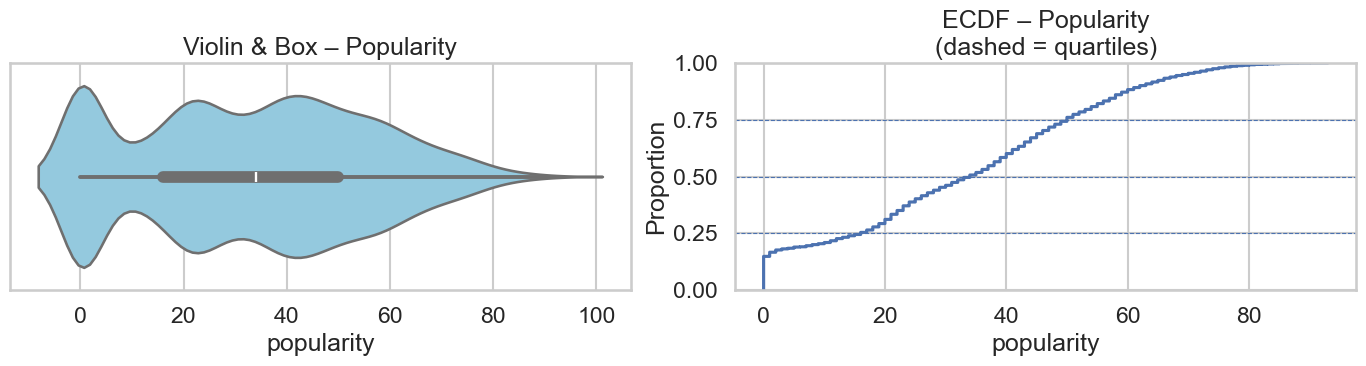

In [74]:
# (c) Violin & boxplot of track popularity + empirical CDF
fig, ax = plt.subplots(1, 2, figsize=(14, 4))

# 1) Box-plus-violin
sns.violinplot(ax=ax[0], x=sample["popularity"], inner="box", color="skyblue")
ax[0].set_title("Violin & Box – Popularity")

# 2) ECDF with quartile lines
sns.ecdfplot(ax=ax[1], data=sample["popularity"])
for q in [0.25, 0.5, 0.75]:
    ax[1].axhline(q, ls="--", lw=0.8)
ax[1].set_title("ECDF – Popularity\n(dashed = quartiles)")
plt.tight_layout()


TODO

What do you learn from these plots?

### 3.2 Factors

Text(0.5, 1.0, 'Danceability distribution')

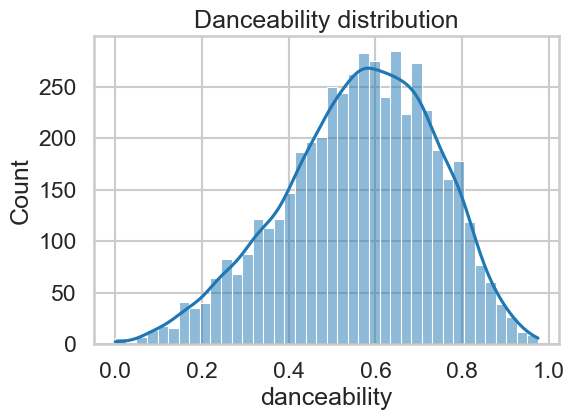

In [75]:
# Continuous feature 
fig, ax = plt.subplots(figsize=(6,4))
sns.histplot(sample['danceability'], bins=40, kde=True, ax=ax, color='tab:blue')
ax.set_title('Danceability distribution')


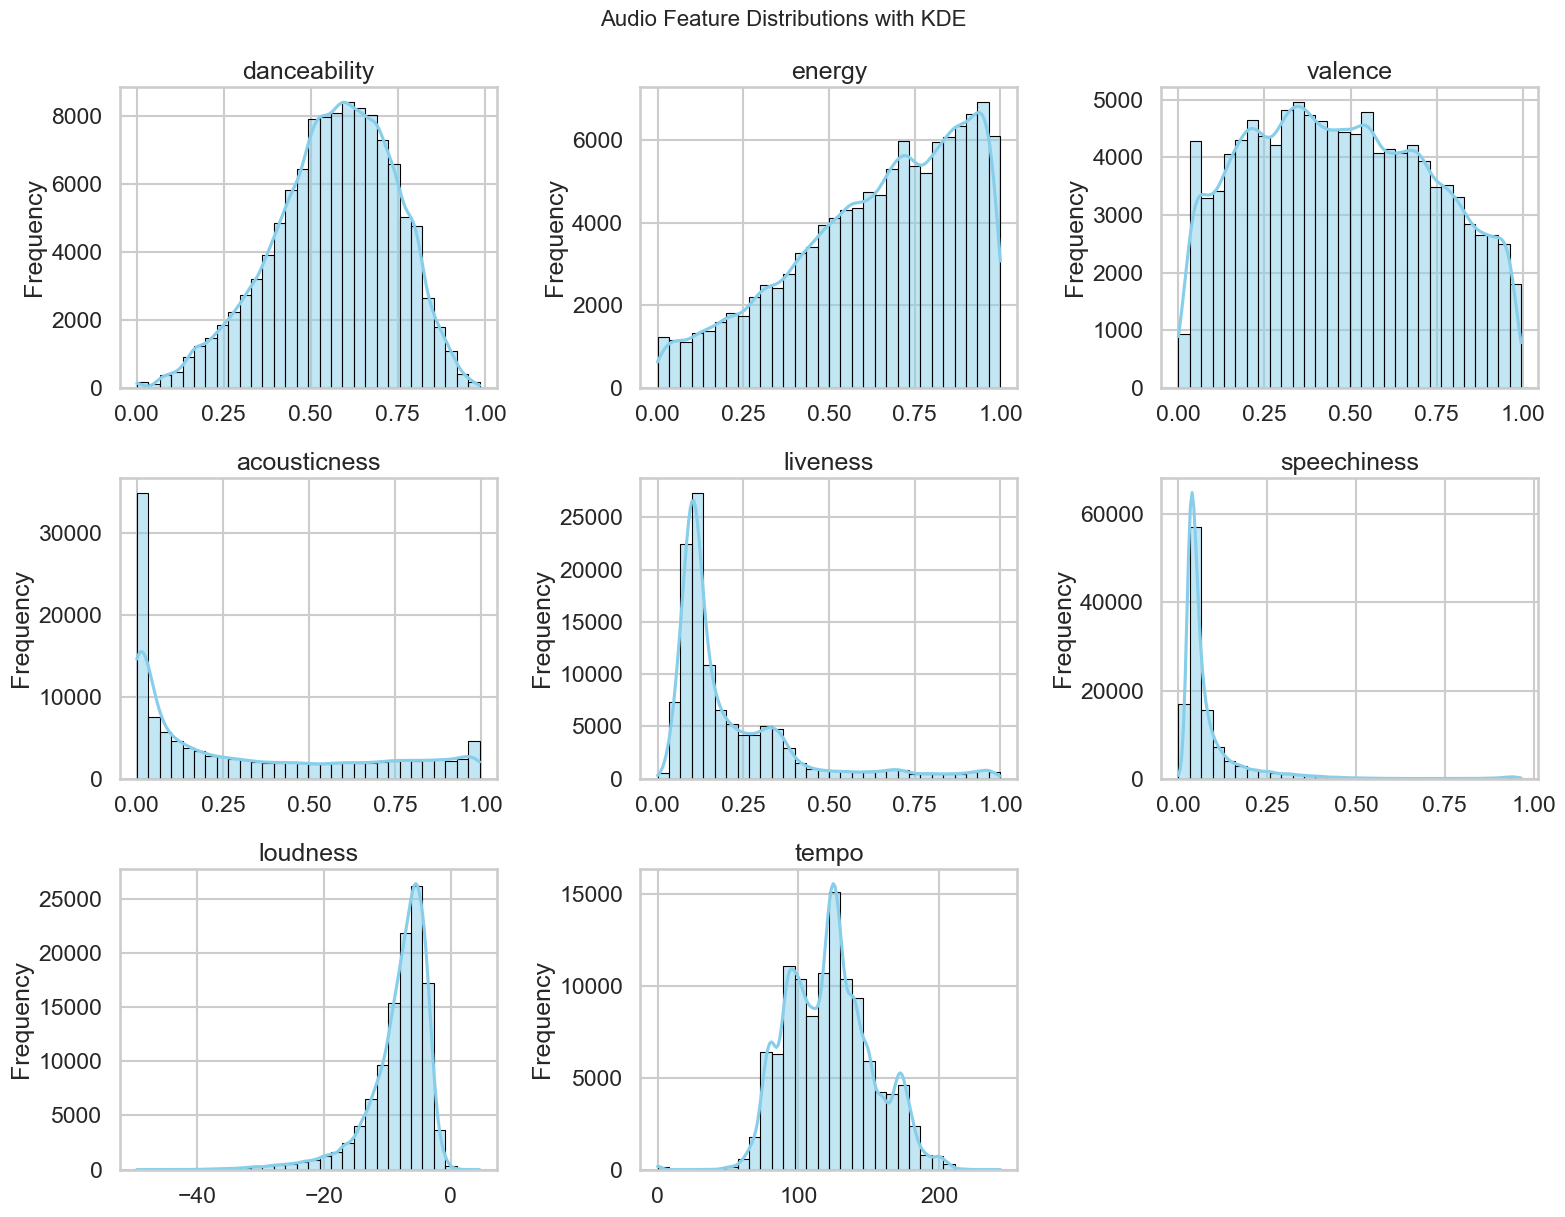

In [76]:
# more plots
import matplotlib.pyplot as plt
import seaborn as sns

audio_features = ['danceability', 'energy', 'valence', 
                  'acousticness', 'liveness', 'speechiness', 
                  'loudness', 'tempo']

plt.figure(figsize=(16, 12))
for i, feature in enumerate(audio_features):
    plt.subplot(3, 3, i + 1)
    sns.histplot(df[feature], bins=30, kde=True, color='skyblue', edgecolor='black')
    plt.title(feature)
    plt.xlabel('')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.suptitle('Audio Feature Distributions with KDE', fontsize=16, y=1.02)
plt.show()

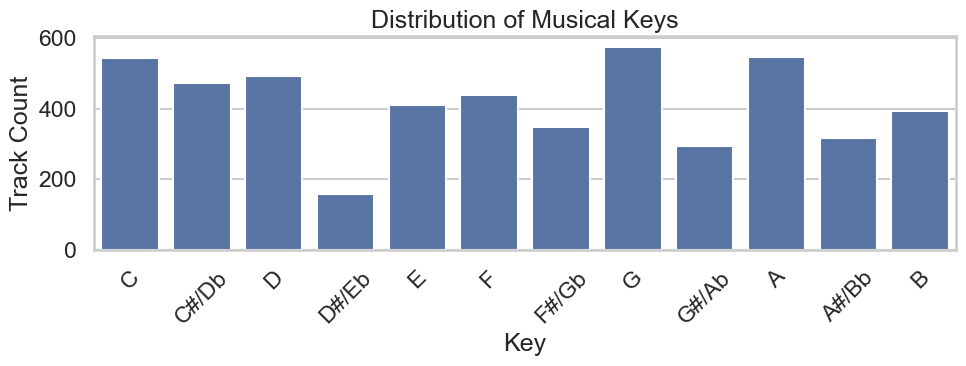

In [77]:
# Categorical features
import matplotlib.pyplot as plt

data = sample if 'sample' in globals() else df


plt.figure(figsize=(10, 4))
sns.countplot(
    x="key_name",
    data=data,
    order=[key_names[k] for k in sorted(key_names)]
)
plt.title("Distribution of Musical Keys")
plt.xlabel("Key")
plt.ylabel("Track Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



> **Tip** There are (too) many visualizations to draw during exploratory analysis. Select the meaningful ones in the final report.

###  3.3 Categorical analysis

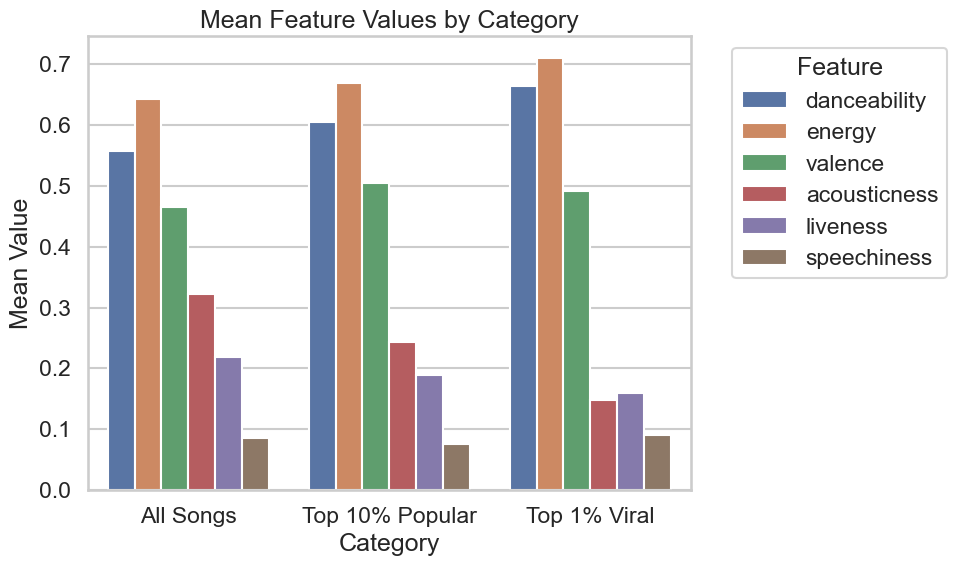

In [78]:
features = ['danceability', 'energy', 'valence', 'acousticness', 'liveness', 'speechiness']
data = data.dropna(subset=features)
df_sorted = data.sort_values(by='popularity', ascending=False)
top_1_percent = int(len(data) * 0.01)
top_10_percent = int(len(data) * 0.10)

viral_songs = df_sorted.iloc[:top_1_percent]
popular_songs = df_sorted.iloc[:top_10_percent]

data['hit_label'] = 0
data.loc[data.index.isin(popular_songs.index), 'hit_label'] = 2
data.loc[data.index.isin(viral_songs.index), 'hit_label'] = 1
data['category'] = 'All Songs'
data.loc[data['hit_label'] == 2, 'category'] = 'Top 10% Popular'
data.loc[data['hit_label'] == 1, 'category'] = 'Top 1% Viral'

mean_values = data.groupby('category')[features].mean().reset_index()
mean_values_features = mean_values.melt(id_vars='category', var_name='Feature', value_name='Mean Value')

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='category', y='Mean Value', hue='Feature', data=mean_values_features,
            order=['All Songs', 'Top 10% Popular', 'Top 1% Viral'])
plt.title('Mean Feature Values by Category')
plt.xlabel('Category')
plt.ylabel('Mean Value')
plt.legend(title='Feature', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## 4 Multivariate summary

### 4.1 Association with popularity 

In [79]:



# features to compare → (column_name, pretty_label)
vars_ = [("danceability", "Danceability"),
         ("energy",       "Energy"),
         ("valence",      "Valence")]

# ╭─────────────────── 2. create 1×3 subplot figure ─────────────────────────╮
fig = make_subplots(
    rows=1, cols=3, shared_yaxes=True,
    subplot_titles=[lbl for _, lbl in vars_]
)

for i, (col, label) in enumerate(vars_, start=1):
    # 2-A scatter cloud (semi-transparent)
    fig.add_trace(
        go.Scatter(
            x=sample[col],
            y=sample["popularity"],
            mode="markers",
            marker=dict(size=4, color="rgba(0,0,0,0.30)"),
            hoverinfo="skip",
        ),
        row=1, col=i
    )

    # 2-B rolling median curve (20 equal-width bins)
    bins = np.linspace(0, 1, 21)
    med = (
        sample.groupby(pd.cut(sample[col], bins))["popularity"]
          .median()
          .reset_index()
          .dropna()
    )
    med["center"] = med[col].apply(lambda x: x.mid)
    fig.add_trace(
        go.Scatter(
            x=med["center"],
            y=med["popularity"],
            mode="lines",
            line=dict(color="red", width=3),
            hoverinfo="skip"
        ),
        row=1, col=i
    )

    fig.update_xaxes(title_text=label, row=1, col=i)

fig.update_yaxes(title_text="Popularity (0–100)", row=1, col=1)
fig.update_layout(
    title="Popularity vs Core Audio Features  (sampled scatter + median trend)",
    height=500, width=1_200, showlegend=False
)

fig.show()


C:\Users\wisdo\AppData\Local\Temp\ipykernel_8628\2646641143.py:28: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\wisdo\AppData\Local\Temp\ipykernel_8628\2646641143.py:28: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\wisdo\AppData\Local\Temp\ipykernel_8628\2646641143.py:28: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [80]:
sample["duration_min"] = sample["duration_ms"] / 60_000           # ms → minutes
sample["tempo_norm"]   = sample["tempo"].clip(30, 220)             # trim extremes

# FIXED: Convert categorical to float before numerical operation
sample["explicit_jit"] = sample["explicit"].astype(float) + np.random.uniform(-0.08, 0.08, len(sample))

# (column, pretty label, is_continuous?)
vars_ = [
    ("tempo_norm",   "Tempo (BPM)",          True),
    ("duration_min", "Duration (min)",       True),
    ("explicit_jit", "Explicit (0 = clean, 1 = explicit)", False),
]

fig = make_subplots(rows=1, cols=3, shared_yaxes=True,
                    subplot_titles=[v[1] for v in vars_])

for i, (col, label, is_cont) in enumerate(vars_, start=1):
    # scatter cloud
    fig.add_trace(
        go.Scatter(
            x=sample[col], y=sample["popularity"],
            mode="markers",
            marker=dict(size=4, color="rgba(0,0,0,0.30)"),
            hoverinfo="skip"
        ),
        row=1, col=i
    )

    # median curve / line
    if is_cont:
        bins = np.linspace(sample[col].min(), sample[col].max(), 21)
        med  = sample.groupby(pd.cut(sample[col], bins))["popularity"].median().dropna()
        centers = [b.mid for b in med.index]
        fig.add_trace(
            go.Scatter(
                x=centers, y=med.values,
                mode="lines", line=dict(color="red", width=3),
                hoverinfo="skip"
            ),
            row=1, col=i
        )
    else:   # explicit flag
        med = sample.groupby("explicit")["popularity"].median()
        fig.add_trace(
            go.Scatter(
                x=[0, 1], y=med.values,
                mode="lines+markers",
                line=dict(color="red", width=3),
                marker=dict(size=8, color="red"),
                hoverinfo="skip"
            ),
            row=1, col=i
        )

    fig.update_xaxes(title_text=label, row=1, col=i)

fig.update_yaxes(title_text="Popularity (0–100)", row=1, col=1)
fig.update_layout(
    title="Popularity vs Tempo • Duration • Explicit Flag  (sampled scatter + median)",
    height=500, width=1_200, showlegend=False
)

fig.show()

C:\Users\wisdo\AppData\Local\Temp\ipykernel_8628\1385472772.py:32: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\wisdo\AppData\Local\Temp\ipykernel_8628\1385472772.py:43: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



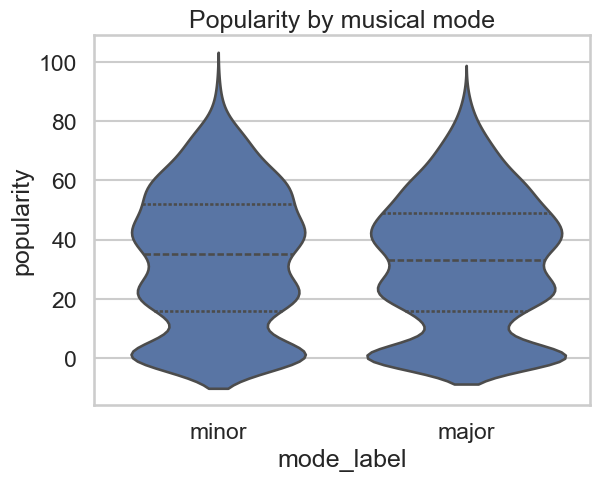

In [81]:

# Solution ▼
sample['mode_label'] = sample['mode'].map({1:'major',0:'minor'}).astype('category')
sns.violinplot(data=sample, x='mode_label', y='popularity', inner='quartile')
plt.title('Popularity by musical mode');


C:\Users\wisdo\AppData\Local\Temp\ipykernel_8628\1210037933.py:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




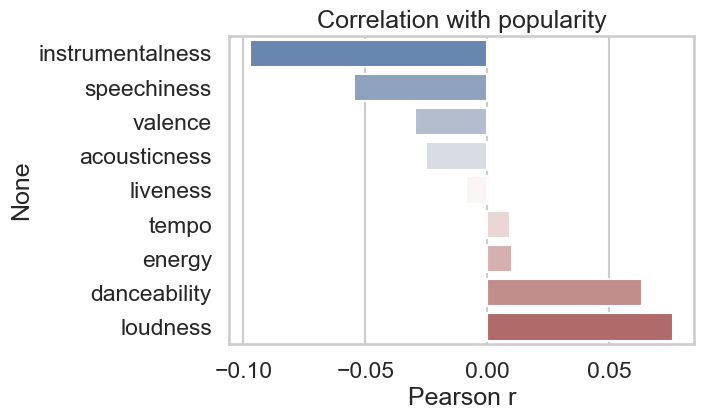

In [82]:

# Solution ▼
num_cols = ['danceability','energy','valence','tempo','loudness',
            'speechiness','acousticness','instrumentalness','liveness','popularity']
corr = sample[num_cols].corr()['popularity'].drop('popularity').sort_values()
plt.figure(figsize=(6,4))
sns.barplot(x=corr.values, y=corr.index, palette='vlag')
plt.title('Correlation with popularity')
plt.xlabel('Pearson r');


### 4.2 Factors

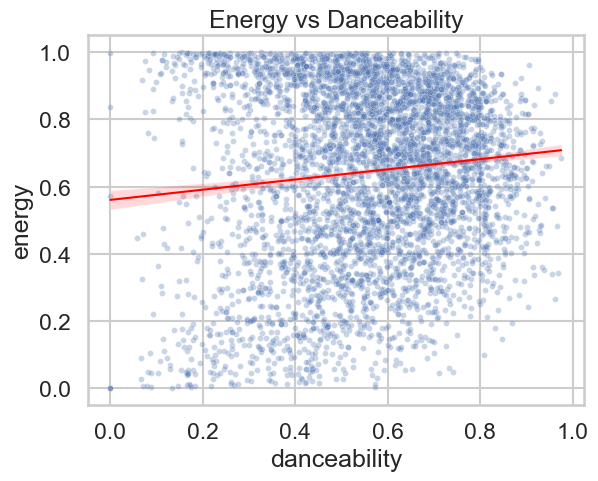

In [83]:

# Solution ▼
sns.scatterplot(data=sample,
                x='danceability', y='energy', alpha=0.3, s=18)
sns.regplot(data=sample, x='danceability', y='energy',
            scatter=False, color='red', line_kws={'linewidth':1.5})
plt.title('Energy vs Danceability');


In [84]:
# Three variables in 3-D

bins   = [-np.inf, 30, 80, np.inf]
labels = ["Low (<30)", "Mid (30-80]", "High (>80)"]
sample["pop_bucket"] = pd.cut(sample["popularity"], bins=bins, labels=labels)

# optional colour palette
palette = {"Low (<30)": "grey", "Mid (30-80]": "orange", "High (>80)": "red"}

fig = px.scatter_3d(
    sample,
    x="danceability",
    y="energy",
    z="valence",
    color="pop_bucket",
    color_discrete_map=palette,
    opacity=0.6,
    height=650,
    title="Danceability × Energy × Valence  (colour = Popularity tier)"
)
fig.update_traces(hoverinfo="skip", marker=dict(size=4))
fig.update_layout(
    legend_title_text="Popularity tier",
    scene=dict(
        xaxis_title="Danceability",
        yaxis_title="Energy",
        zaxis_title="Valence"
    )
)

fig.show()


TODO 

What else do you want to explore in this dataset?

## 5 Can we do some clustering?
To support the evaluation of our unsupervised learning results, we introduce a new column called "hit_label" to the dataset. This label serves as a reference point for validating how well the clustering or grouping matches the underlying popularity of the songs.</p>

Songs in the top 1% of popularity are assigned a label of 1 (representing "viral songs").
Songs ranked within the top 10% but not the top 1% are assigned a label of 2 (representing "popular songs").
All other songs, outside the top 10%, are assigned a label of 0 (representing "non-popular songs").
By using the hit_label, we can later compare the clustering results against these categories to assess whether the unsupervised learning methods naturally separate viral and popular songs without explicitly using the popularity score during training.

In [85]:
# preprocessing
from sklearn.model_selection import train_test_split
df_sorted = data.sort_values(by='popularity', ascending=False)

# Define top 1% and 10% cuts
top_1_percent = int(len(data) * 0.01)
top_10_percent = int(len(data) * 0.10)

# Select viral and popular songs
viral_songs = df_sorted.iloc[:top_1_percent]
popular_songs = df_sorted.iloc[:top_10_percent]

# Assign hit labels
data['hit_label'] = 0
data.loc[data.index.isin(popular_songs.index), 'hit_label'] = 2
data.loc[data.index.isin(viral_songs.index), 'hit_label'] = 1

# Optional: category label for plotting
data['category'] = 'All Songs'
data.loc[data['hit_label'] == 2, 'category'] = 'Top 10% Popular'
data.loc[data['hit_label'] == 1, 'category'] = 'Top 1% Viral'
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_scaled = scaler.fit_transform(data[audio_features])
x_scaled_df = pd.DataFrame(x_scaled, columns=audio_features, index=data.index)
x_scaled_df['hit_label'] = data['hit_label']
x_scaled_df['category'] = data['category']

# Split Data into Training and Testing Sets
x_full_df = x_scaled_df[audio_features]
y_full_df = x_scaled_df['hit_label']
x_train, x_test, y_train, y_test = train_test_split(
    x_full_df, y_full_df, test_size=0.2, random_state=42, stratify=y_full_df
)
assert(x_train.shape[1]==x_test.shape[1])

data['hit_label'] = 0
data.loc[data.index.isin(popular_songs.index), 'hit_label'] = 2
data.loc[data.index.isin(viral_songs.index), 'hit_label'] = 1

hit_label_dictionary = {0: 'All Songs', 1: 'Top 1% Viral Songs', 2: 'Top 10% Popular Songs'}
print("\nTraining set hit_label distribution:")
train_counts = y_train.value_counts()
for label, count in train_counts.items():
    print(f"  {hit_label_dictionary[label]}: {count}  ({count/len(y_train)*100:.2f}%)")

print("\nTesting set hit_label distribution:")
test_counts = y_test.value_counts()
for label, count in test_counts.items():
    print(f"  {hit_label_dictionary[label]}: {count}  ({count/len(y_test)*100:.2f}%)")



Training set hit_label distribution:
  All Songs: 3600  (90.00%)
  Top 10% Popular Songs: 360  (9.00%)
  Top 1% Viral Songs: 40  (1.00%)

Testing set hit_label distribution:
  All Songs: 900  (90.00%)
  Top 10% Popular Songs: 90  (9.00%)
  Top 1% Viral Songs: 10  (1.00%)



Mean Feature Values by hit_label (Training Set):
                       danceability    energy   valence  acousticness  \
All Songs                 -0.026555 -0.020541 -0.004888      0.037894   
Top 1% Viral Songs         0.645911  0.258188  0.190119     -0.494661   
Top 10% Popular Songs      0.219241  0.075575  0.104995     -0.179666   

                       liveness  speechiness  loudness     tempo  
All Songs              0.020549     0.018428 -0.038633  0.008290  
Top 1% Viral Songs    -0.255630     0.023056  0.566955 -0.075130  
Top 10% Popular Songs -0.150697    -0.084528  0.250485 -0.108632  

Feature Differences (Hit Songs - Non-Hit Songs):
loudness        0.320765
danceability    0.288462
acousticness   -0.249059
liveness       -0.181740
valence         0.118395
energy          0.114378
tempo          -0.113572
speechiness    -0.092198
dtype: float64

Top 3 Features for Viral/Popular Songs: ['loudness', 'danceability', 'acousticness']


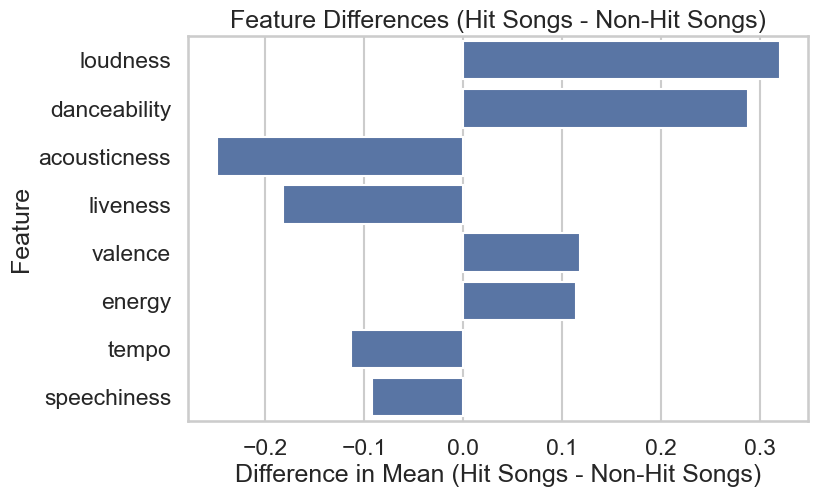

In [86]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

train_df = pd.DataFrame(x_train, columns=audio_features)
train_df['hit_label'] = y_train

feature_means = train_df.groupby('hit_label')[audio_features].mean()
feature_means.index = ['All Songs', 'Top 1% Viral Songs', 'Top 10% Popular Songs']
print("\nMean Feature Values by hit_label (Training Set):")
print(feature_means)

# Compute mean feature values for Hit Songs  vs. Non-Hit Songs 
hit_songs_mean = train_df[train_df['hit_label'].isin([1, 2])][audio_features].mean()
non_hit_songs_mean = train_df[train_df['hit_label'] == 0][audio_features].mean()
feature_differences = hit_songs_mean - non_hit_songs_mean
feature_differences = feature_differences.sort_values(key=abs, ascending=False)

print("\nFeature Differences (Hit Songs - Non-Hit Songs):")
print(feature_differences)

# Select the top 3 features based on the largest absolute differences
top_features = feature_differences.index[:3].tolist()
print(f"\nTop 3 Features for Viral/Popular Songs: {top_features}")

plt.figure(figsize=(8, 5))
sns.barplot(x=feature_differences.values, y=feature_differences.index)
plt.title('Feature Differences (Hit Songs - Non-Hit Songs)')
plt.xlabel('Difference in Mean (Hit Songs - Non-Hit Songs)')
plt.ylabel('Feature')
plt.show()

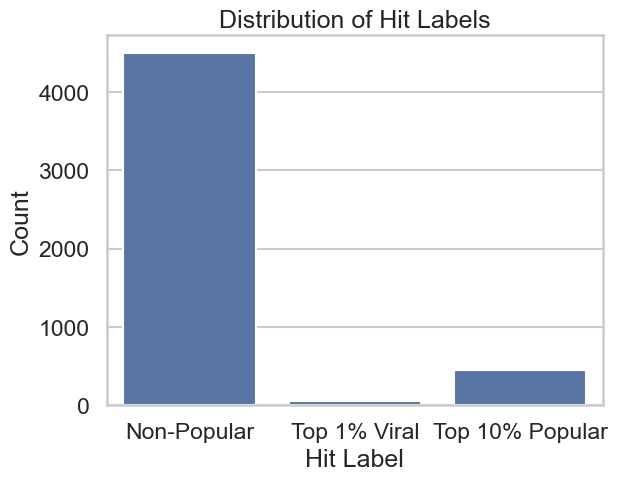

In [87]:
sns.countplot(x='hit_label', data=data)
plt.title('Distribution of Hit Labels')
plt.xlabel('Hit Label')
plt.ylabel('Count')
plt.xticks(ticks=[0,1,2], labels=['Non-Popular', 'Top 1% Viral', 'Top 10% Popular'])
plt.show()

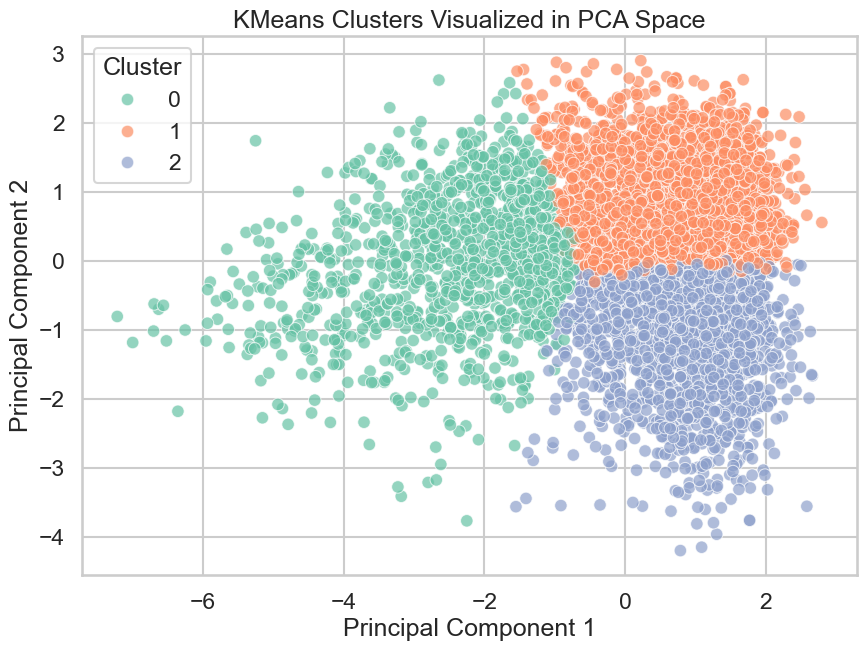

In [88]:
from sklearn.cluster import KMeans

# Try 3 clusters (you can tune this later)
kmeans = KMeans(n_clusters=3, random_state=42)
x_scaled_df['cluster'] = kmeans.fit_predict(x_scaled_df[audio_features])


from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

pca = PCA(n_components=2)
components = pca.fit_transform(x_scaled_df[audio_features])
x_scaled_df['PC1'] = components[:, 0]
x_scaled_df['PC2'] = components[:, 1]

plt.figure(figsize=(10, 7))
sns.scatterplot(data=x_scaled_df, x='PC1', y='PC2', hue='cluster', palette='Set2', alpha=0.7)
plt.title('KMeans Clusters Visualized in PCA Space')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()



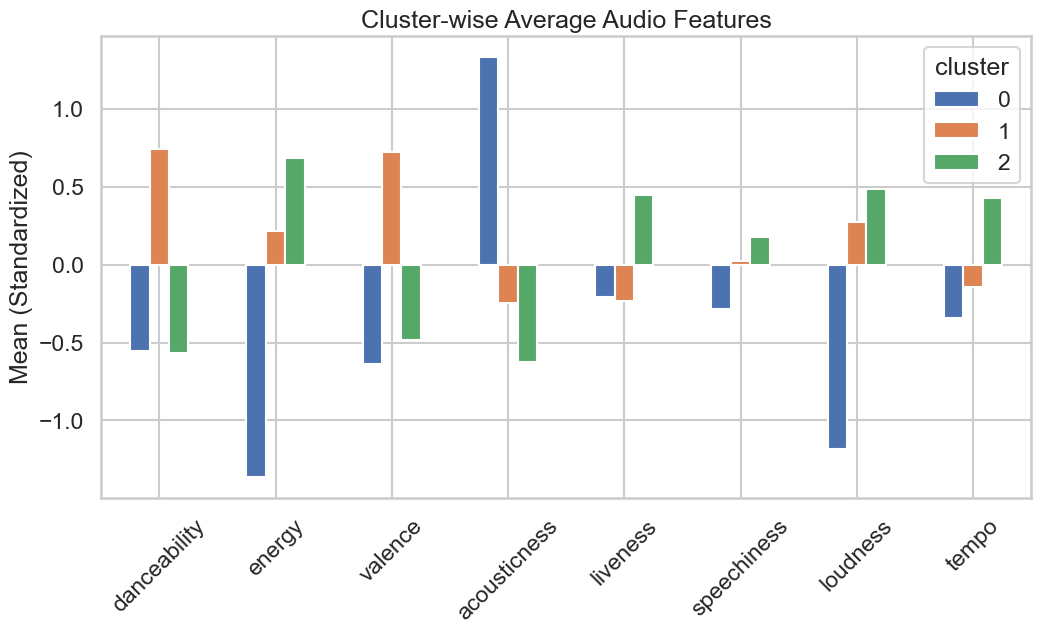

In [89]:
cluster_means = x_scaled_df.groupby('cluster')[audio_features].mean().T
cluster_means.plot(kind='bar', figsize=(12, 6))
plt.title('Cluster-wise Average Audio Features')
plt.ylabel('Mean (Standardized)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

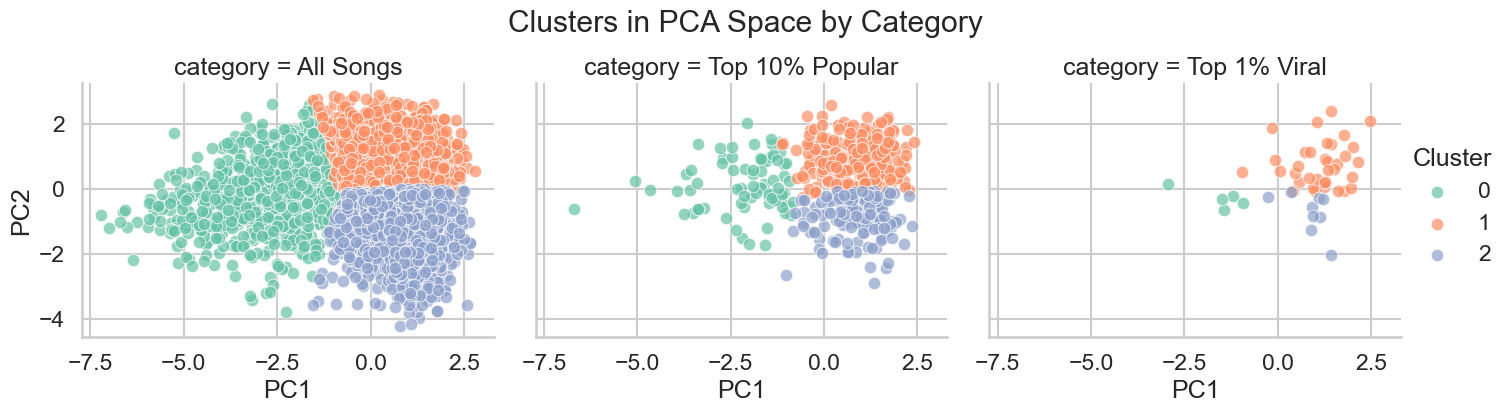

In [90]:
import seaborn as sns
#sns.crosstab(x_scaled_df['cluster'], x_scaled_df['hit_label'], normalize='index') * 100
import matplotlib.pyplot as plt

g = sns.FacetGrid(x_scaled_df, col='category', hue='cluster', palette='Set2', height=4, aspect=1.2)
g.map_dataframe(sns.scatterplot, x='PC1', y='PC2', alpha=0.7)
g.add_legend(title='Cluster')
g.set_axis_labels('PC1', 'PC2')
g.fig.suptitle('Clusters in PCA Space by Category', y=1.05)
plt.show()

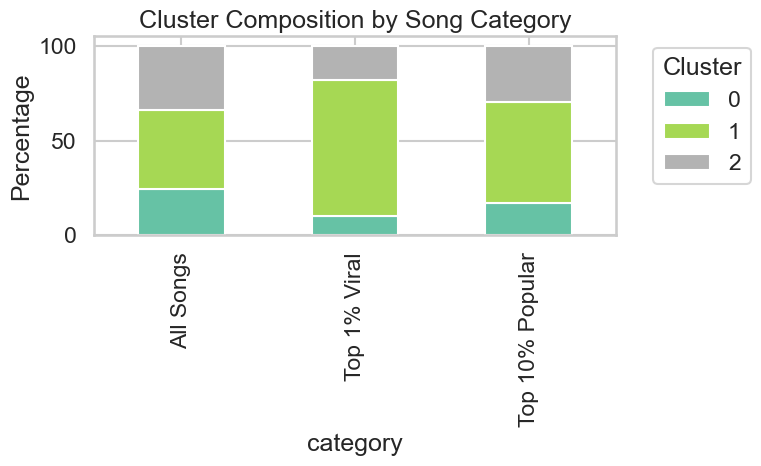

In [91]:
import pandas as pd

cluster_dist = pd.crosstab(x_scaled_df['category'], x_scaled_df['cluster'], normalize='index') * 100
cluster_dist.plot(kind='bar', stacked=True, colormap='Set2', figsize=(8, 5))
plt.ylabel('Percentage')
plt.title('Cluster Composition by Song Category')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()


In [92]:
cluster_summary = x_scaled_df.groupby('cluster')[audio_features].mean()
print(cluster_summary)

         danceability    energy   valence  acousticness  liveness  \
cluster                                                             
0           -0.554479 -1.361849 -0.637530      1.333857 -0.206862   
1            0.740878  0.216962  0.722951     -0.249495 -0.232281   
2           -0.565179  0.686521 -0.482978     -0.624523  0.447623   

         speechiness  loudness     tempo  
cluster                                   
0          -0.283867 -1.185827 -0.343370  
1           0.020833  0.276675 -0.143458  
2           0.174674  0.484189  0.429610  


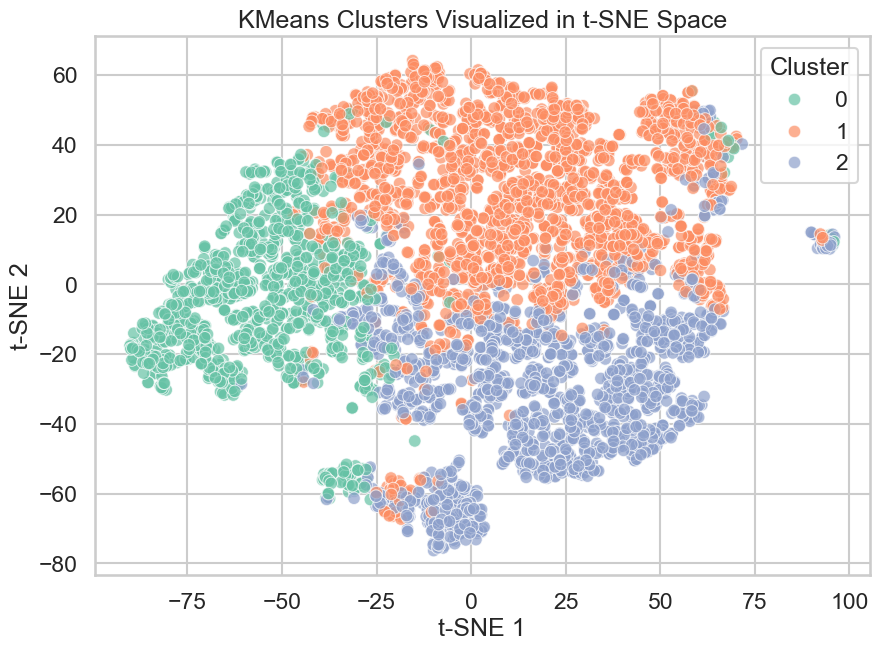

In [93]:
## other method

from sklearn.manifold import TSNE

# Run t-SNE to reduce dimensions to 2
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
tsne_results = tsne.fit_transform(x_scaled_df[audio_features])

# Add to DataFrame
x_scaled_df['TSNE1'] = tsne_results[:, 0]
x_scaled_df['TSNE2'] = tsne_results[:, 1]


import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
sns.scatterplot(data=x_scaled_df, x='TSNE1', y='TSNE2', hue='cluster', palette='Set2', alpha=0.7)
plt.title('KMeans Clusters Visualized in t-SNE Space')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()


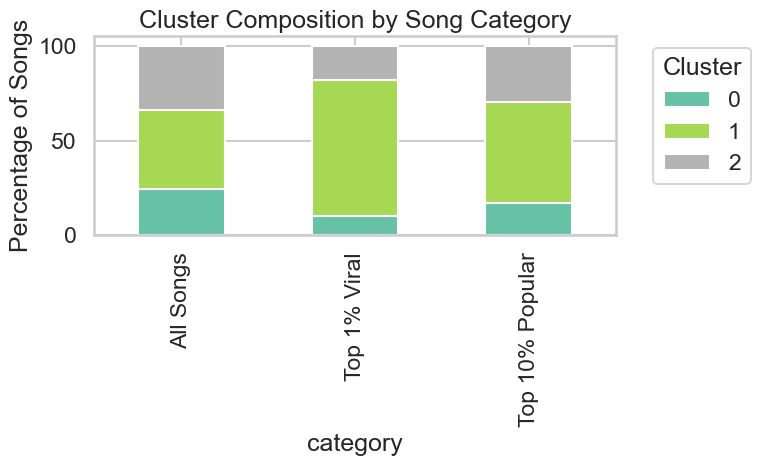

In [94]:
import pandas as pd

# Compute the percentage of each cluster within each category
cluster_dist = pd.crosstab(x_scaled_df['category'], x_scaled_df['cluster'], normalize='index') * 100
import matplotlib.pyplot as plt

# Plot stacked bar chart
cluster_dist.plot(kind='bar', stacked=True, colormap='Set2', figsize=(8, 5))

plt.ylabel('Percentage of Songs')
plt.title('Cluster Composition by Song Category')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



In [95]:
cluster_summary = x_scaled_df.groupby('cluster')[audio_features].mean()
print(cluster_summary)

         danceability    energy   valence  acousticness  liveness  \
cluster                                                             
0           -0.554479 -1.361849 -0.637530      1.333857 -0.206862   
1            0.740878  0.216962  0.722951     -0.249495 -0.232281   
2           -0.565179  0.686521 -0.482978     -0.624523  0.447623   

         speechiness  loudness     tempo  
cluster                                   
0          -0.283867 -1.185827 -0.343370  
1           0.020833  0.276675 -0.143458  
2           0.174674  0.484189  0.429610  
